In [1]:
import cmdstanpy as csp

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

C:\Users\mirar\anaconda3\envs\stan\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
data_all = pd.read_csv("data_50000.csv")

In [3]:
data_all.columns

Index(['template_id', 'median_z', 'mean_z', 'minchi2', 'mode_z', 'z_sigma68',
       'z_sigma', 'z_mc'],
      dtype='object')

In [55]:
N = data_all.shape[0]
# log_minchi2 = np.log(data_all["minchi2"])
median_z = data_all["median_z"]
z_sigma = data_all["z_sigma"]
group_id = data_all["template_id"] + 1
num_templates = len(np.unique(group_id))

a1 = 1
b1 = 1
a2 = 1
b2 = 1
nu = 3
lambda_var = 1

In [5]:
print(np.min(group_id))
print(np.max(group_id))

1
47


In [56]:
data = {'N': N, 
        'J': num_templates,
        'z_sigma': z_sigma,
        'median_z': median_z,
        'group_id': group_id,
        'a1': a1,
        'b1': b1,
        'a2': a2,
        'b2': b2,
        'nu': nu,
        'lambda': lambda_var,}

In [57]:
model = csp.CmdStanModel(stan_file = 'hierarchical-regression.stan')
sample = model.sample(data = data, seed = 1, chains = 1,
                      iter_sampling = 1000, iter_warmup = 1000,
                      show_progress = False, show_console = False)

12:20:38 - cmdstanpy - INFO - CmdStan start processing
12:20:38 - cmdstanpy - INFO - Chain [1] start processing
12:25:59 - cmdstanpy - INFO - Chain [1] done processing
12:25:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hierarchical-regression.stan', line 37, column 4 to column 36)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hierarchical-regression.stan', line 37, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!


In [69]:
# how to save a model
# sample.save_csvfiles("model-data-50000-ratio")

# how to read a saved file
sample = csp.from_csv("model-data-cut-5000/hierarchical-regression-20240422121707.csv")

In [70]:
alpha_list = sample.stan_variable("alpha")
beta_list = sample.stan_variable("beta")

In [71]:
print(alpha_list.shape)

(1000, 47)


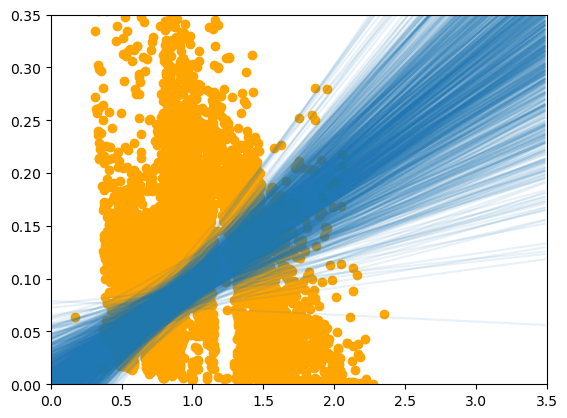

In [72]:
group_index = 1

zs = np.arange(0, np.max(median_z), np.max(median_z)/1000)
segs = []
for i in range(alpha_list.shape[0]):
    data = alpha_list[i][group_index] + beta_list[i][group_index]*zs
    segs.append(((zs[0], data[0]), (zs[-1], data[-1])))

# get first group of data
group1_sigma = np.array(z_sigma)[np.where(group_id==group_index)]
group1_z = np.array(median_z)[np.where(group_id==group_index)]

# plot the group data

ln_coll = matplotlib.collections.LineCollection(segs, alpha=0.1)
ax = plt.gca()
ax2 = plt.scatter(group1_z, group1_sigma, color='orange')
ax.add_collection(ln_coll)
ax.set_xlim(0, 3.5)    
ax.set_ylim(0.0, 0.35)
plt.draw()